In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import os.path
from loguru import logger
import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize


In [16]:
# def download_data():
#     '''
#         download historial data from deribit exchange
#     '''
#     import nest_asyncio
#     nest_asyncio.apply()
#     from tardis_dev import datasets
    
#     datasets.download(
#         exchange="deribit",
#         data_types=["options_chain"],
#         from_date="2022-12-01T00:00:00",
#         to_date="2022-12-01T00:01:00",
#         symbols=["OPTIONS"]
#     )
#     !gzip -d *.gz
    

In [5]:
fname = 'deribit_options_chain_2022-12-01_OPTIONS.csv'
# if not os.path.isfile(fname):
#     download_data()

In [6]:
df = pd.read_csv(f"./datasets/{fname}", nrows=1000000)


In [7]:
def select_data(df: pd.DataFrame, currency: str  = "BTC"):
    btc_ind = [symbol.startswith(currency) for symbol in df.underlying_index]

    columns_to_drop = ['exchange', 'symbol', 'local_timestamp', 'underlying_index', 
                       'delta', 'gamma', 'vega', 'theta', 'rho']
    
    btc = df[btc_ind].reset_index(drop=True).drop(columns_to_drop, axis=1)

    #tau is time before expiration in years
    btc['tau'] = (btc.expiration - btc.timestamp) / 1e6 / 3600 / 24 / 365
    #days before exp
    btc['days'] = (btc['tau'] * 365).astype(int)

    K = btc.strike_price.values
    F = btc.underlying_price.values

    payoff = np.maximum( F - K, 0.0 )
    payoff[btc.type == 'put'] = np.maximum( K - F, 0.0)[btc.type == 'put']

    btc["payoff"] = payoff

    btc['mid_price'] = 0.5 * (btc.ask_price + btc.bid_price)
    
    btc_grouped = btc.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)
    
    put = btc_grouped[btc_grouped.type == 'put'].drop(['type'], axis=1).reset_index(drop=True)

    call = btc_grouped[btc_grouped.type == 'call'].drop(['type'], axis=1).reset_index(drop=True)
    
    return put, call

In [8]:
put, call = select_data(df, currency="ETH")


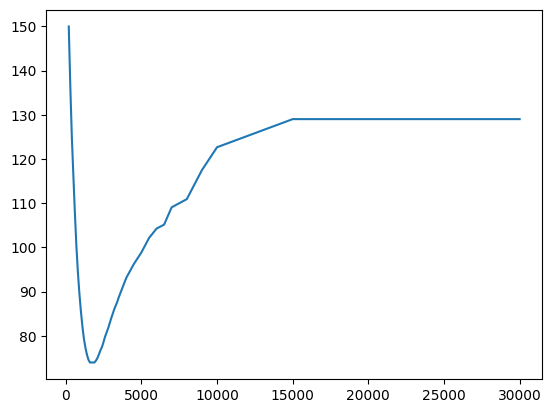

In [9]:
single_expiration_date =  call.sample(1).expiration.iloc[0]
call_single_exp = call[call["expiration"] == single_expiration_date]
put_single_exp = put[put["expiration"] == single_expiration_date]

# plt.plot(put_single_exp["strike_price"], put_single_exp["mark_iv"])
plt.plot(call_single_exp["strike_price"], call_single_exp["mark_iv"])
# plt.show()


In [10]:
days = set(call.days.values)
days

{1, 8, 29, 57, 120, 211, 302}

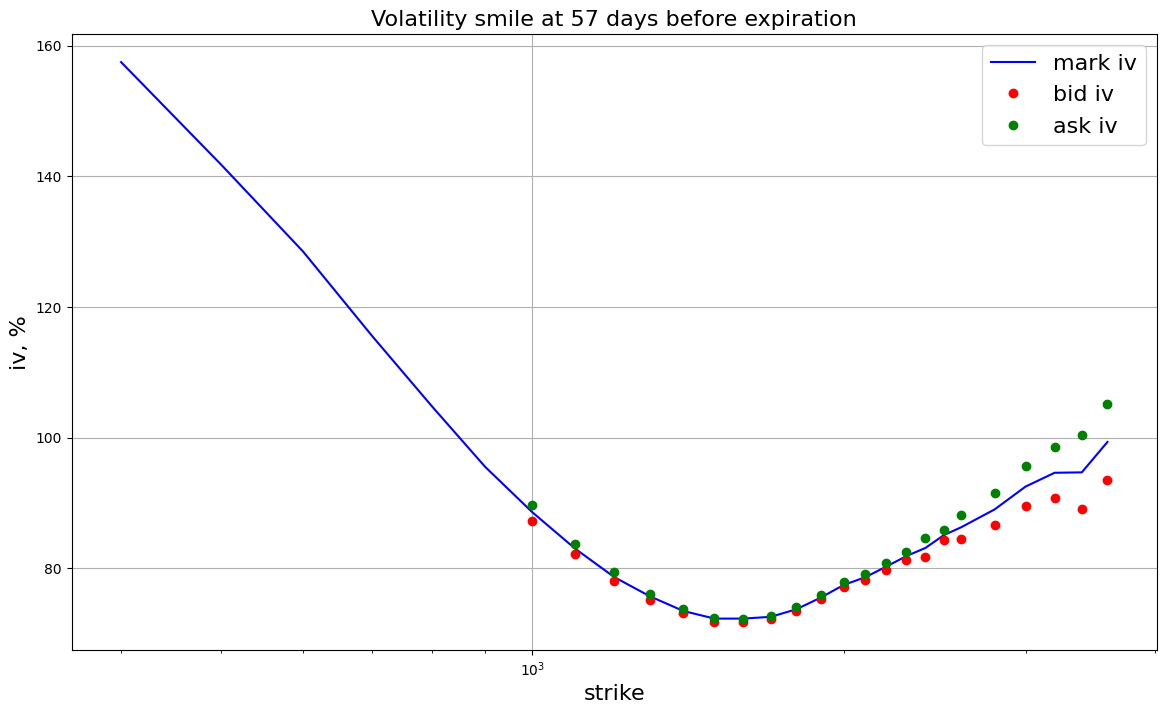

In [11]:
day = 57
call_ = call[call.days == day]
plt.figure(figsize=(14, 8))
plt.title(f"Volatility smile at {day} days before expiration", fontsize=16)
plt.semilogx(call_.strike_price.values, call_.mark_iv, '-b', label='mark iv')
plt.semilogx(call_.strike_price.values, call_.bid_iv, 'or', label='bid iv')
plt.semilogx(call_.strike_price.values, call_.ask_iv, 'og', label='ask iv')
plt.ylabel("iv, %", fontsize=16)
plt.xlabel("strike", fontsize=16)
plt.legend(fontsize=16)
plt.grid()

# Калибровка

In [12]:
class SABR:
    def __init__(self, data: pd.DataFrame) -> None:
        """Class to model the volatility smile"""
        self.data = data

        # let it be fixed as in the artice
        self.beta = 0.5

        self.T = data.iloc[0].tau
        self.underlying_price =  data.iloc[0].underlying_price
        
        # start params for optimization
        self.x0 = np.array([0.99, 0.00, 0.99])
      
        self.bounds = [(0.0001, 1000.0), (-0.9999, 0.9999), (0.0001, 1000.0)]


    def _sigmaB(
        self, f: float, K: float, T: float, alpha: float, rho: float, v: float
    ) -> float:
        """Function to count modeled volatility"""
        first_part_of_numerator = (
            (1 - self.beta) ** 2 / 24 * alpha**2 / (f * K) ** (1 - self.beta)
        )
        second_part_of_numerator = (
            (rho * self.beta * v * alpha) / 4 * (f * K) ** ((1 - self.beta) / 2)
        )
        third_part_of_numerator = (2 - 3 * rho**2) * v**2 / 24
        numerator = alpha * (
            1
            + self.T
            * (
                first_part_of_numerator
                + second_part_of_numerator
                + third_part_of_numerator
            )
        )

        first_part_of_denominator = (1 - self.beta) ** 2 / 24 * (np.log(f / K)) ** 2
        second_part_of_denominator = (1 - self.beta) ** 4 / 1920 * (np.log(f / K)) ** 4
        denominator = (f * K) ** ((1 - self.beta) / 2) * (
            1 + first_part_of_denominator + second_part_of_denominator
        )

        z = v / alpha * (f * K) ** ((1 - self.beta) / 2) * np.log(f / K)

        xi = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))

        return numerator / denominator * z / xi

    def _plot_results(self) -> None:
        """Function to plot results"""

        def get_sigmas_for_set_of_params(alpha: float, rho: float, v: float) -> None:
            """Inner function to count sigmas for current optimization method"""
            self.volatilities = []
            self.test_strikes = np.linspace(0, 5000, 100)
            for strike in self.test_strikes:
                sigma_modeled = self._sigmaB(
                    self.underlying_price, strike, self.T, alpha, rho, v
                )
                self.volatilities.append(sigma_modeled)

        get_sigmas_for_set_of_params(
            self.alpha_scipy, self.rho_scipy, self.v_scipy
        )

        fig, ax = plt.subplots(figsize=(15, 7))
        ax = sns.scatterplot(x = "strike_price", y = "mark_iv", data=self.data, 
                             color = "black",
                             label="scipy optimizer")

        ax1 = sns.lineplot(
            x=self.test_strikes,
            y=self.volatilities,
            label="market volatilities",
            color="blue",
        ).set_title(f"T = {int(self.T * 365)} days")

    def _vol_square_error(self, x: np.ndarray) -> np.float64:
        """Function to get the argmin function we want to optimize"""
        # init market volatiliteis
        smile = self.data.mark_iv.to_numpy()
        vols = []
        for index, row in self.data.iterrows():
            vols.append(
                self._sigmaB(
                    self.underlying_price, row["strike_price"], self.T, x[0], x[1], x[2]
                )
            )
        return sum((vols - smile) ** 2)


    def _minimize_scipy(self) -> np.float64:
        """Optimization with scipy optimizer"""
        return minimize(self._vol_square_error, x0=self.x0, bounds=self.bounds)

    def run(self) -> None:
        """Run optimization and plot results"""
        # optimization via scipy
        optimum_scipy = self._minimize_scipy()
        self.alpha_scipy, self.rho_scipy, self.v_scipy = optimum_scipy.x
        logger.info(
            f"Optimal params for T = {int(self.T*365)} days: alpha = {self.alpha_scipy}, rho = {self.rho_scipy}, v = {self.v_scipy}"
        )
        # plot market values and modeled function
        self._plot_results()
        return self.volatilities


2022-12-07 23:09:56.700 | INFO     | __main__:run:103 - Optimal params for T = 1 days: alpha = 603.488981484195, rho = -0.000506812570653684, v = 127.52172068827008
2022-12-07 23:09:57.038 | INFO     | __main__:run:103 - Optimal params for T = 8 days: alpha = 298.29673941434675, rho = -0.0008893209230599315, v = 69.52335481574582
2022-12-07 23:09:57.365 | INFO     | __main__:run:103 - Optimal params for T = 29 days: alpha = 306.53710557055956, rho = -0.0002809195062215651, v = 36.03697923598569
2022-12-07 23:09:57.668 | INFO     | __main__:run:103 - Optimal params for T = 57 days: alpha = 338.21267977707925, rho = -0.00035373878009855165, v = 26.25976517346498
2022-12-07 23:09:57.956 | INFO     | __main__:run:103 - Optimal params for T = 120 days: alpha = 317.2489489465439, rho = 0.00026324414325277557, v = 14.398777247240501
2022-12-07 23:09:58.309 | INFO     | __main__:run:103 - Optimal params for T = 211 days: alpha = 294.7721166632665, rho = 0.0005742427571227691, v = 9.26613933240

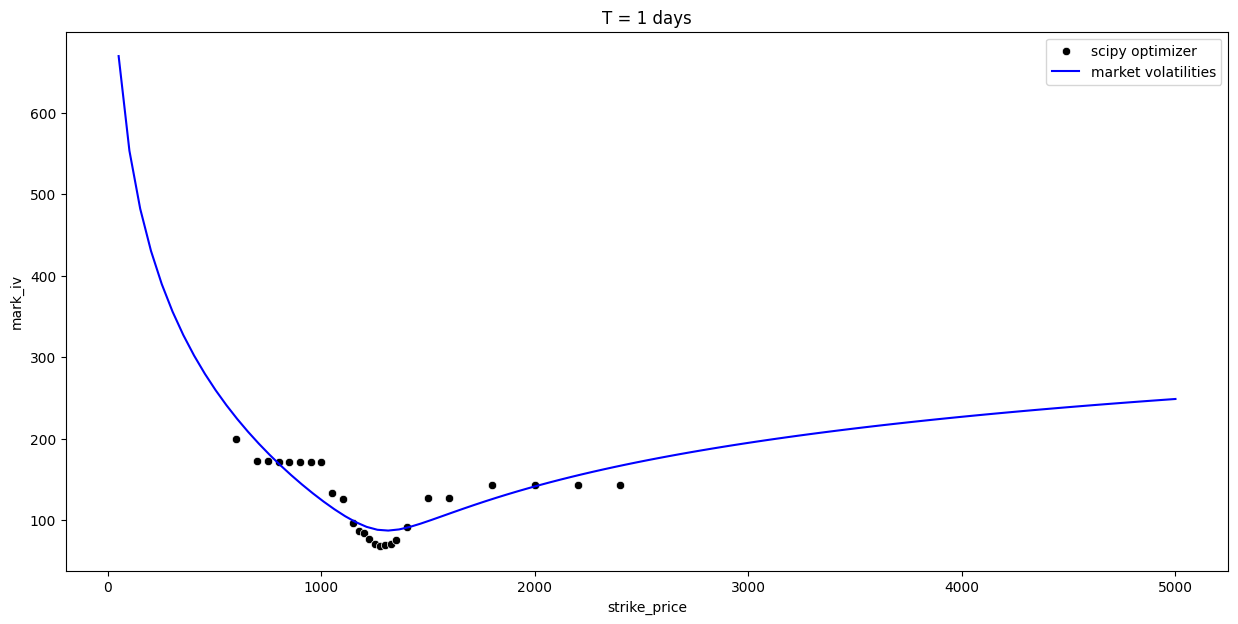

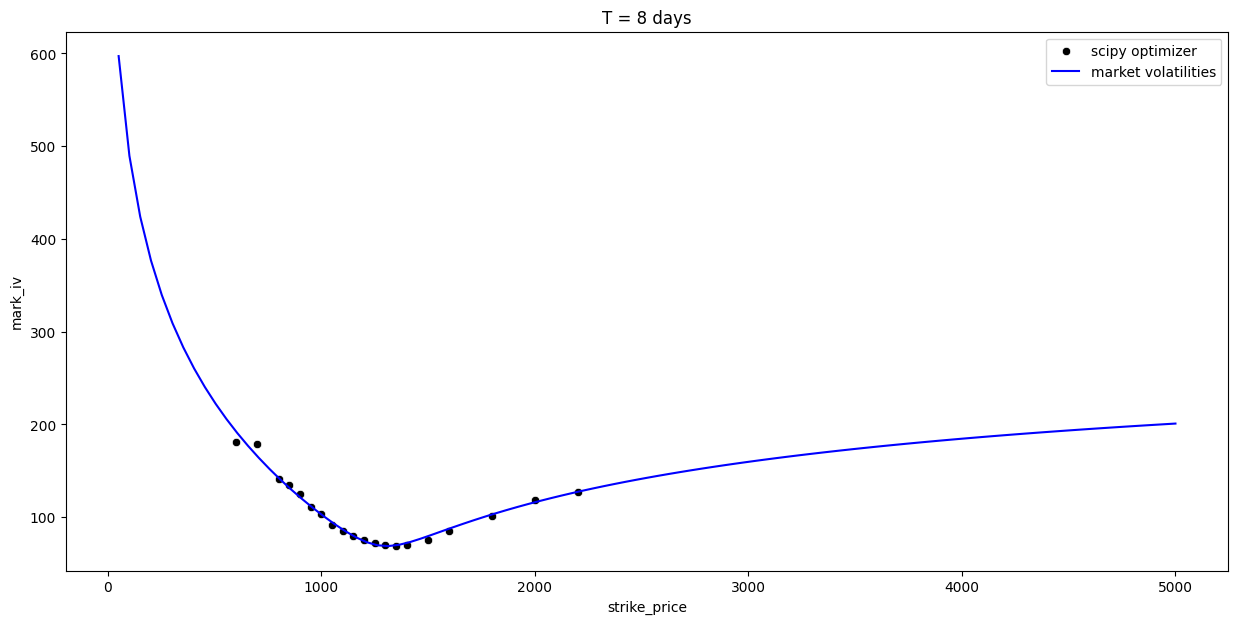

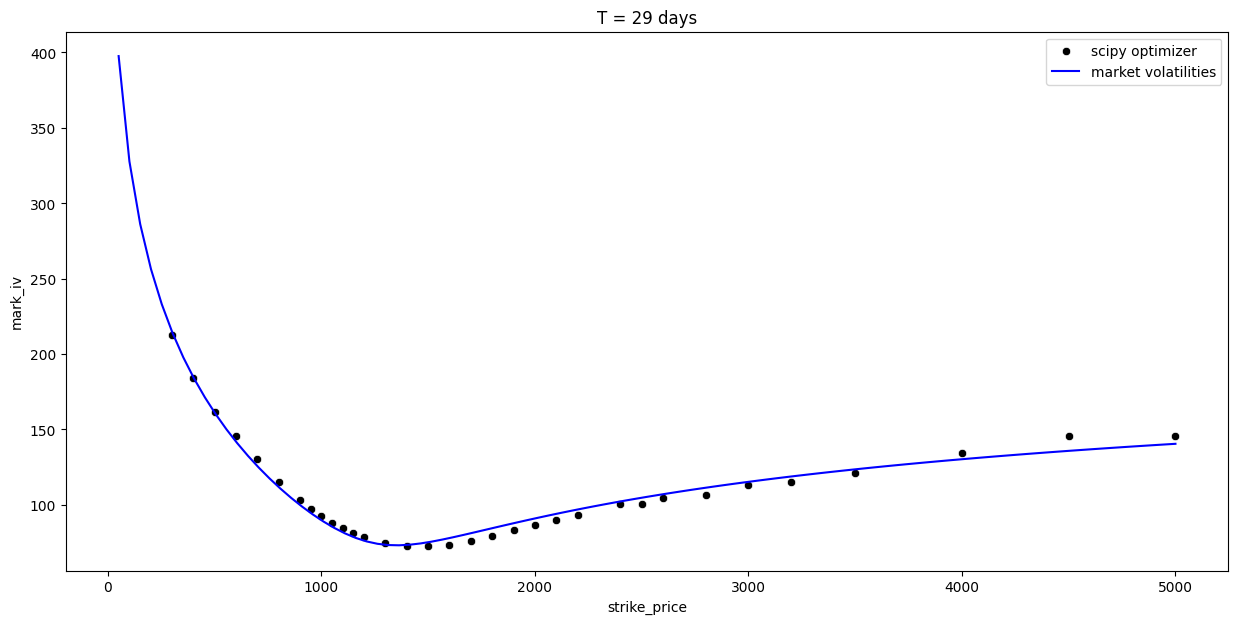

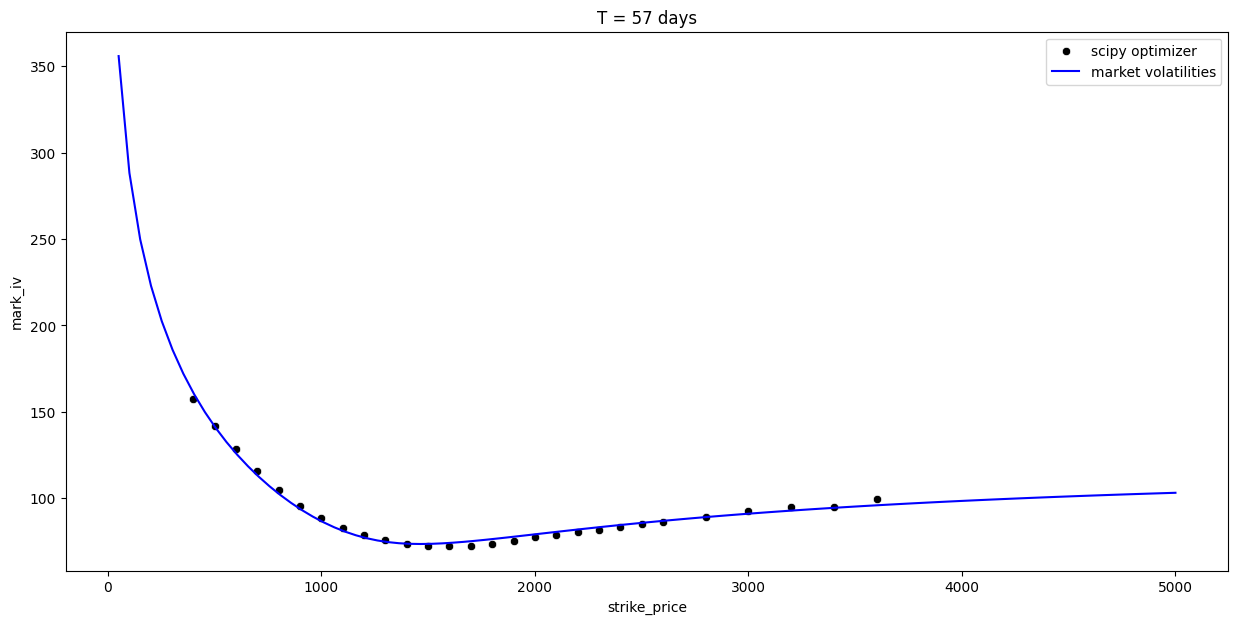

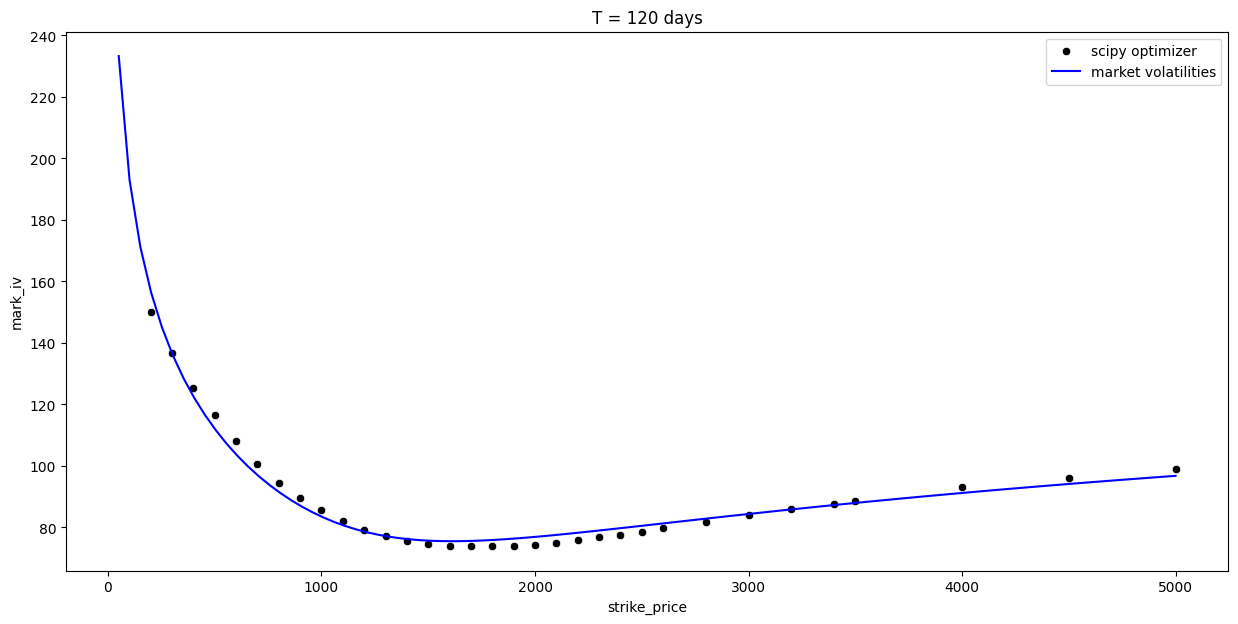

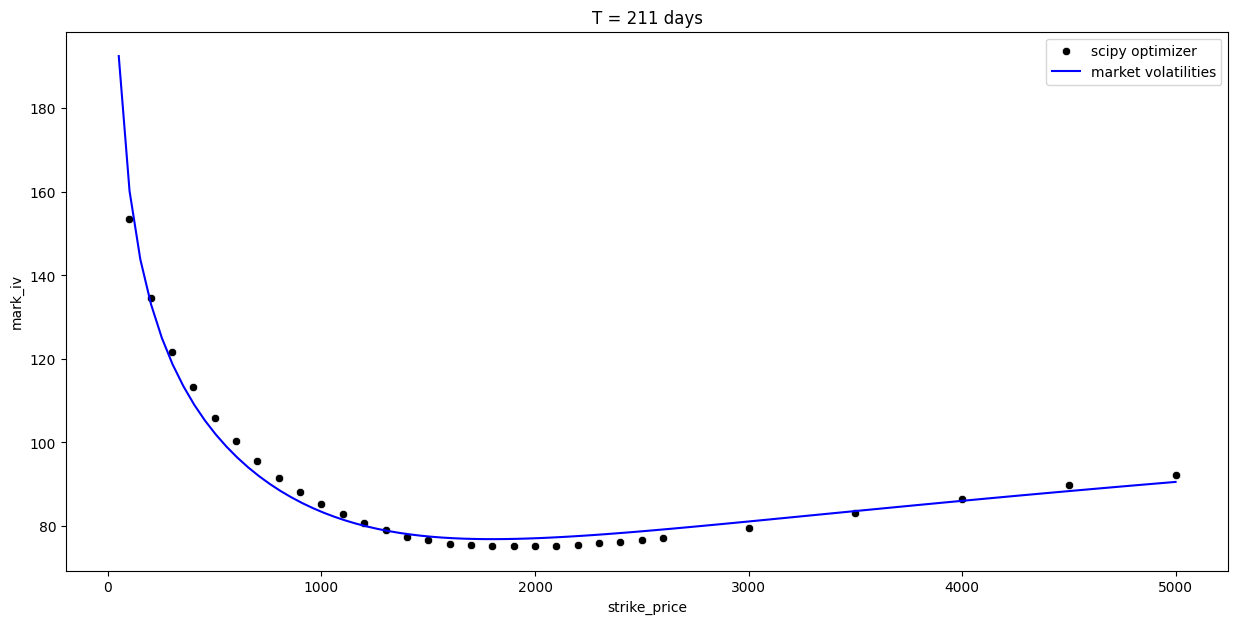

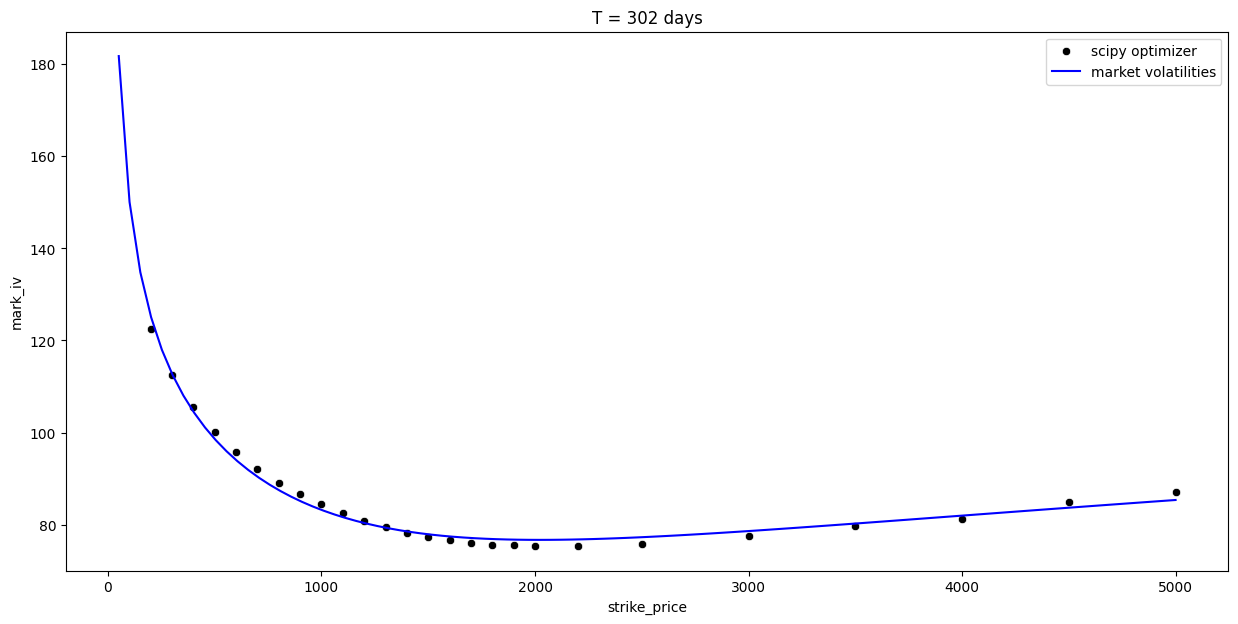

In [13]:
# выкидываем из выборки опционы, которые deep ITM, так как по ним маленькая волатисльность
# call_ = call_[call_["strike_price"]<=b10000]
list_of_vols = []
days = sorted(list(set(call.days.values)))
for day in days:
    call_ = call[call.days == day]
    put_ = put[put.days == day]
    
    cc = call_[call_["strike_price"]<=call_["underlying_price"]]
    pp = put_[put_["strike_price"]>=put_["underlying_price"]]
    dff = pd.concat([cc, pp])
    dff = dff[dff["strike_price"]<=5_000]
    
    sabr = SABR(dff)
    vols = sabr.run()
    list_of_vols.append(vols)

In [17]:
x, y, z = np.linspace(0, 5000, 100), days, np.array(list_of_vols)
sh_0, sh_1 = z.shape
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True), 
                 )

fig.update_layout(title='Volatility surface', autosize=False,
                  width=1000, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                 scene=dict(
        xaxis_title='Strike, $',
        yaxis_title='Maturite, days',
        zaxis_title='Volatility',
    )
                  
                 )
fig.show()